# CAMSL Dataset Journal Notebook

In [1]:
%matplotlib inline
import datetime
from datetime import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import pickle
import os

import warnings
warnings.filterwarnings("ignore")
plt.rc('font', family='serif')

In [2]:
customer_info_df = pd.read_csv("./sample_data/customer_info.csv")

In [3]:
TOU_customers = []
NON_TOU_customers = []
Control_customers = []
for _, raw in customer_info_df.iterrows():
    customer_id = int(raw["id"])
    tou_type = int(raw["tou"])
    if tou_type != 1:
        NON_TOU_customers.append(customer_id)
        if tou_type == 2:
            Control_customers.append(customer_id)
    else:
        TOU_customers.append(customer_id)
print("TOU:", len(TOU_customers))
print("NON TOU: ", len(NON_TOU_customers))
print("Control: ", len(Control_customers))

TOU: 2
NON TOU:  3
Control:  0


In [4]:
def csv_to_consumption_dic(target_customers):
    files = glob.glob("./sample_data/consumption_data/*/*.csv")
    print("total files: ", len(files))
    consumption_data = {}
    for file_path in files:
        customer_id = int(file_path.split("/")[-2])
        # include only in target_customers
        if not customer_id in target_customers:
            continue

        if customer_id not in consumption_data.keys():
            consumption_data[customer_id] = {}
        df = pd.read_csv(file_path, header=None)

        for _, row in df.iterrows():
            date_str, time_stamp, consumption = row
            _dt = datetime.datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
            if _dt.date() not in consumption_data[customer_id].keys():
                consumption_data[customer_id][_dt.date()] = [consumption]
            else:
                consumption_data[customer_id][_dt.date()].append(consumption)
    return consumption_data

In [5]:
all_customers = TOU_customers + Control_customers
all_consumption = csv_to_consumption_dic(all_customers)

total files:  95


In [6]:
# describe dataset
all_customers = list(all_consumption.keys())
print("# of all customers: ", len(all_customers))
print("# of valid TOU: ", len([a for a in all_customers if a in TOU_customers]))
print("# of valid NON-TOU: ", len([a for a in all_customers if a in NON_TOU_customers]))
print("start_date: ", min([min(v.keys()) for v in all_consumption.values()]))
print("end_date: ", max([max(v.keys()) for v in all_consumption.values()]))
print("total data points: ", len(all_consumption[TOU_customers[0]])*48)

# of all customers:  2
# of valid TOU:  2
# of valid NON-TOU:  0
start_date:  2017-06-01
end_date:  2018-12-31
total data points:  27792


In [7]:
import codecs
df = pd.read_csv("./sample_data/holiday_Japan.csv")
holidays = df["date"].apply(lambda x: dt.strptime(x, "%Y-%m-%d").date()).tolist()

In [8]:
def is_weekday(date):
    if date.weekday() < 5 and date not in holidays:
        return True
    else:
        return False

def extract_average_consumption(year_month_list=[(2018, 4)], target_ids=None, weekday=True):
    consumption_list = []
    for customer_id, d_c_dic in all_consumption.items():
        customer_consumption = []
        if target_ids is not None and customer_id not in target_ids:
            continue

        for d, v in d_c_dic.items():
            if weekday == True and is_weekday(d) == False:
                continue
            if weekday == False and is_weekday(d) == True:
                continue
            
            year_month = (d.year, d.month)
            if year_month in year_month_list and len(v) == 48 and np.nan not in v and None not in v: 
                customer_consumption.append(v)
        consumption_list.extend(customer_consumption)
    return np.nanmean(consumption_list, axis=0)

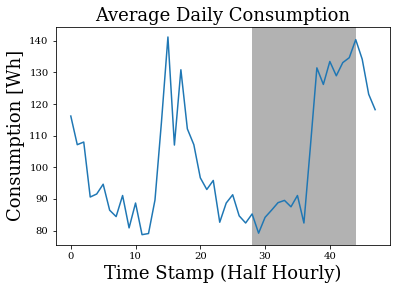

In [9]:
plt.title("Average Daily Consumption", fontsize=18)
plt.ylabel("Consumption [Wh]", fontsize=18)
plt.xlabel("Time Stamp (Half Hourly)", fontsize=18)
plt.axvspan(28.0, 44.0, facecolor='k', alpha=0.3)
plt.plot(extract_average_consumption([(2018, 4), (2018, 5)], target_ids=TOU_customers, weekday=True))